In [2]:
import tensorflow as tf
import datetime

In [3]:
# make sure TensorFlow can see the GPU
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [4]:
# use the built-in datasets
mnist = tf.keras.datasets.mnist

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

(60000, 28, 28)


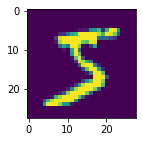

In [32]:
# check out a few images from the train dataset
print(x_train.shape)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(2,2))
fig.add_subplot(1,1,1)
plt.imshow(x_train[0])
plt.show()

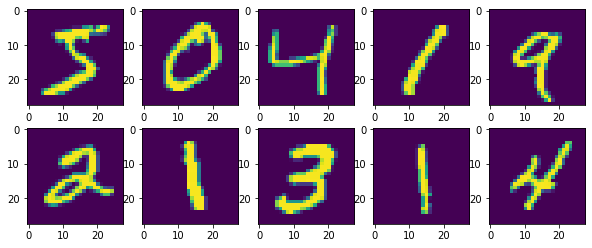

In [29]:
# plot a few more training images
rows = 2
cols = 5
fig = plt.figure(figsize=(10,4))
for i in range(rows * cols):
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(x_train[i])
plt.show()

In [6]:
def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28,28)), 
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2), 
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [12]:
model = create_model()
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [46]:
now_str = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Tensorboard log dir for training parameters
log_dir = "logs/fit/"+now_str
# Log dir for images (e.g. to store confusion matrix as a image)
log_dir_images = "logs/fit_images/"+now_str



In [62]:
## some helper functions to generate confusion matrix as an image
import itertools
import io
def plot_confusion_matrix(cm, class_names):
  figure = plt.figure(figsize=(8, 8))
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion matrix")
  plt.colorbar()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names, rotation=45)
  plt.yticks(tick_marks, class_names)

  # Normalize the confusion matrix.
  cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

  # Use white text if squares are dark; otherwise black.
  threshold = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    color = "white" if cm[i, j] > threshold else "black"
    plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  return figure
def plot_to_image(figure):
  # Save the plot to a PNG in memory.
  buf = io.BytesIO()
  plt.savefig(buf, format='png')
  # Closing the figure prevents it from being displayed directly inside
  # the notebook.
  plt.close(figure)
  buf.seek(0)
  # Convert PNG buffer to TF image
  image = tf.image.decode_png(buf.getvalue(), channels=4)
  # Add the batch dimension
  image = tf.expand_dims(image, 0)
  return image

In [63]:
import numpy as np
import sklearn.metrics



file_writer_cm = tf.summary.create_file_writer(log_dir_images + '/cm')
class_names=[str(i) for i in range(10)]


# function for logging confusion matrix as an image to Tensorboard log dir
# this function will be called at the end of each training epoch
def log_cm(epoch, logs):
    # use the trained model to predict on test data
    test_pred_raw = model.predict(x_test)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(y_test, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [64]:
# declare callbacks
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

cm_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_cm)

In [65]:
model.fit(x=x_train, 
          y=y_train, 
          epochs=10, 
          validation_data=(x_test, y_test),
          callbacks=[tensorboard_cb, cm_cb],
          verbose=0
         )